Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import ScalableLib.classifier.Multiband as multiband
import ScalableLib.base.plot as plot


In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


IndexError: list index out of range

Read the Results folder.

In [3]:
survey = 'ZTF'
path = os.path.join('../../03_TrainModels/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../../03_TrainModels/ZTF/Results/Fold_1',
 '../../03_TrainModels/ZTF/Results/Fold_2',
 '../../03_TrainModels/ZTF/Results/Fold_3',
 '../../03_TrainModels/ZTF/Results/Fold_4',
 '../../03_TrainModels/ZTF/Results/Fold_5',
 '../../03_TrainModels/ZTF/Results/Fold_6',
 '../../03_TrainModels/ZTF/Results/Fold_7']

In [4]:
folder_name = 'Results'
path = os.path.join('.', folder_name,'')
if not os.path.exists(path):
    os.mkdir(path)

For each fold, read the models and evaluate on the test set. Save the results

In [5]:
label_order = ['SNIa', 'QSO','AGN', 'Blazar', 'YSO', 'CV/Nova', 'RRL', 'LPV', 'E', ]

In [6]:
# Containers to store the results
reports_folds = []
cm_folds = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/Results/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./Results', fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    
    
    
    result_path = os.path.join('./Results', fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, labels=label_order)
    cm_folds.append(cm_fold)


2024-08-29 13:03:17.475215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:02:00.0, compute capability: 8.6


../../02_CreateRecords/ZTF/Folds/Fold_1/test/*.tfrecord


2024-08-29 13:03:18.563268: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-29 13:03:33.001646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


              precision    recall  f1-score   support

         AGN       0.66      0.60      0.63       484
      Blazar       0.70      0.59      0.64       218
     CV/Nova       0.85      0.83      0.84       152
           E       0.92      0.95      0.94      2000
         LPV       0.99      1.00      0.99      1863
         QSO       0.89      0.92      0.90      2000
         RRL       0.94      0.93      0.94      2000
        SNIa       1.00      0.92      0.96       101
         YSO       0.84      0.79      0.81       159

    accuracy                           0.91      8977
   macro avg       0.87      0.84      0.85      8977
weighted avg       0.91      0.91      0.91      8977

../../02_CreateRecords/ZTF/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

         AGN       0.67      0.60      0.63       484
      Blazar       0.70      0.57      0.63       218
     CV/Nova       0.82      0.77      0.79       152
           E       0.9

In [7]:
statistic = 'mean'
mean, std = plot.obtain_accumulated_metrics(reports_folds, metric=statistic, label_order=label_order)
display(mean)
display(std)

,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.99,0.88,0.65,0.73,0.85,0.81,0.94,0.99,0.92
recall,0.95,0.92,0.59,0.57,0.75,0.80,0.93,1.00,0.94
f1-score,0.97,0.90,0.62,0.64,0.80,0.81,0.93,1.00,0.93
support,101.00,2000.00,484.00,218.00,159.00,152.00,2000.00,1863.00,2000.00


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.009037,0.004067,0.012553,0.016625,0.022449,0.017810,0.004133,0.001078,0.003752
recall,0.022453,0.003156,0.012536,0.013589,0.033905,0.028938,0.004838,0.000703,0.003872
f1-score,0.010009,0.003128,0.012286,0.008554,0.015232,0.019227,0.002269,0.000646,0.002815
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
def plot_confusion_matrix(cm_folds,
                           labels_,
                           title='Confusion matrix',
                           statistic='mean',
                           survey=None,
                           cmap=plt.cm.Greens,
                           save_path=None,
                           nep=0,
                          ):

    """ This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_folds = 100*np.array(cm_folds)
    font = {'family' : "Times New Roman",
            'weight' : 'normal'}
    plt.clf()
    np.set_printoptions(precision=2)

    fig = plt.figure(figsize=(10,10), dpi=250)
    ax = plt.gca()

    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 22

    num_classes = len(labels_)


    plt.rc('font', size=SMALL_SIZE, **font)          # controls default text sizes
    plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    plt.title(title)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [i for i in labels_], rotation=45)
    plt.yticks(tick_marks, [i for i in labels_])

    
    
    if statistic=='mean':
        center_cm = np.mean(cm_folds, axis=0)
        std_cm  = np.std(cm_folds, axis=0)

        cm_test = 100.0*np.array(cm_folds)

        cm_pos = std_cm
        cm_neg = std_cm

    elif statistic=='median':
        center_cm = np.median(cm_folds, axis=0)
        q_25 = np.quantile(cm_folds, 0.25, axis=0)
        q_75 = np.quantile(cm_folds, 0.75, axis=0)

        cm_pos = q_75-center_cm
        cm_neg = center_cm-q_25

    else:
        print('Error: Not implemented')
        return None

    im = ax.imshow(center_cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)    
    fig.canvas.draw() 
    tt = fig.gca().transData.inverted()
   
    
#     coords_container = []
#     [coords_container.append([]) for i in range(num_classes)]
#     [coords_container[i].append([]) for i in range(num_classes) for j in range(num_classes)]
    
    for i, j in itertools.product(range(num_classes), range(num_classes)):
        if center_cm[i, j]>1e-2:
            center = round(center_cm[i, j], 2)
            pos = round(cm_pos[i,j], 2)
            neg = round(cm_neg[i,j], 2)

            super_text = f'${pos}}}$'
            middle = f'${center}$'
            sub_text = f'${neg}}}$'

            # Small shift in x to accomodate the super/sub scripts
            mid_text = plt.text(j-0.075, i+0.075, middle, horizontalalignment="center", fontdict={'fontsize':SMALL_SIZE}, bbox={'alpha':0.0, 'lw':0, 'pad':0}
                ,color="white" if center_cm[i, j] > 80 else "black")

#             coords_container[i][j] = mid_text
            new_coords = tt.transform_bbox(mid_text.get_window_extent()).get_points()
#             coords_container[i][j] = new_coords


#             x0,y0 = new_coords[0,0], new_coords[0,1]
#             x1,y1 = new_coords[1,0], new_coords[1,1]
#             plt.scatter([x0,x0,x1,x1], [y0,y1, y0,y1], s=5, color='red')
            
            if statistic=='mean':
                sub_text = f''

            
            sup_text = plt.text(new_coords[1,0]-0.115, new_coords[1,1], super_text, verticalalignment = 'bottom', horizontalalignment="left", fontdict={'fontsize':SMALL_SIZE-3}
                 ,color="white" if center_cm[i, j] > 80 else "black")
            bot_text = plt.text(new_coords[1,0]-0.115, new_coords[0,1]-0.01, sub_text, verticalalignment = 'top', horizontalalignment="left", fontdict={'fontsize':SMALL_SIZE-3}
                 ,color="white" if center_cm[i, j] > 80 else "black")          
            
        elif center_cm[i, j]>0:
            plt.text(j, i, '$<0.01$', horizontalalignment="center"
                 ,color="black",fontdict = {'size':SMALL_SIZE-2,'weight': 'normal'})


    

    if survey=='Gaia':
            # Horizontal Upper RR Lyrae
            plt.hlines(2.5, 2.5, 4.5, alpha=1,lw=2, color='black')
            # Horizontal Lower RR Lyrae
            plt.hlines(4.5, 2.5, 4.5, alpha=1,lw=2, color='black')
            # Vertical Left RR Lyrae
            plt.vlines(2.5, 2.5, 4.5, alpha=1,lw=2, color='black')
            # Vertical Right RR Lyrae
            plt.vlines(4.5, 2.5, 4.5, alpha=1,lw=2, color='black')

            # Horizontal  CEP
            # plt.hlines(-0.5, -0.5, 1.5, alpha=1,lw=2)
            # Horizontal Upper CEP
            plt.hlines(1.5, -0.5, 1.5, alpha=1,lw=2, color='black')
            # Vertical Left CEP
            # plt.vlines(-0.49, -0.5, 1.5, alpha=1,lw=2)
            # Vertical Right CEP
            plt.vlines(1.5, -0.5, 1.5, alpha=1,lw=2, color='black')
    elif survey=='ZTF':
            # Horizontal Lower Transients
            plt.hlines(0.5, -0.5, 0.5, alpha=1,lw=2, color='black')
            # Vertical Right Transients
            plt.vlines(0.5, 0.5, -0.5, alpha=1,lw=2, color='black')

            # Horizontal Lower Stochastic
            plt.hlines(5.5, 0.5, 5.5, alpha=1,lw=2, color='black')
            # Horizontal Upper Stochastic
            plt.hlines(0.5, 0.5, 5.5, alpha=1,lw=2, color='black')
            # Vertical Left Stochastic
            plt.vlines(0.5, 0.5, 5.5, alpha=1,lw=2, color='black')
            # Vertical Right Stochastic
            plt.vlines(5.5, 0.5, 5.5, alpha=1,lw=2, color='black')


            # Horizontal Upper Periodic
            plt.hlines(5.5, 5.5, 8.5, alpha=1,lw=2, color='black')
            # Vertical Left Periodic
            plt.vlines(5.5, 5.5, 8.5, alpha=1,lw=2, color='black')

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

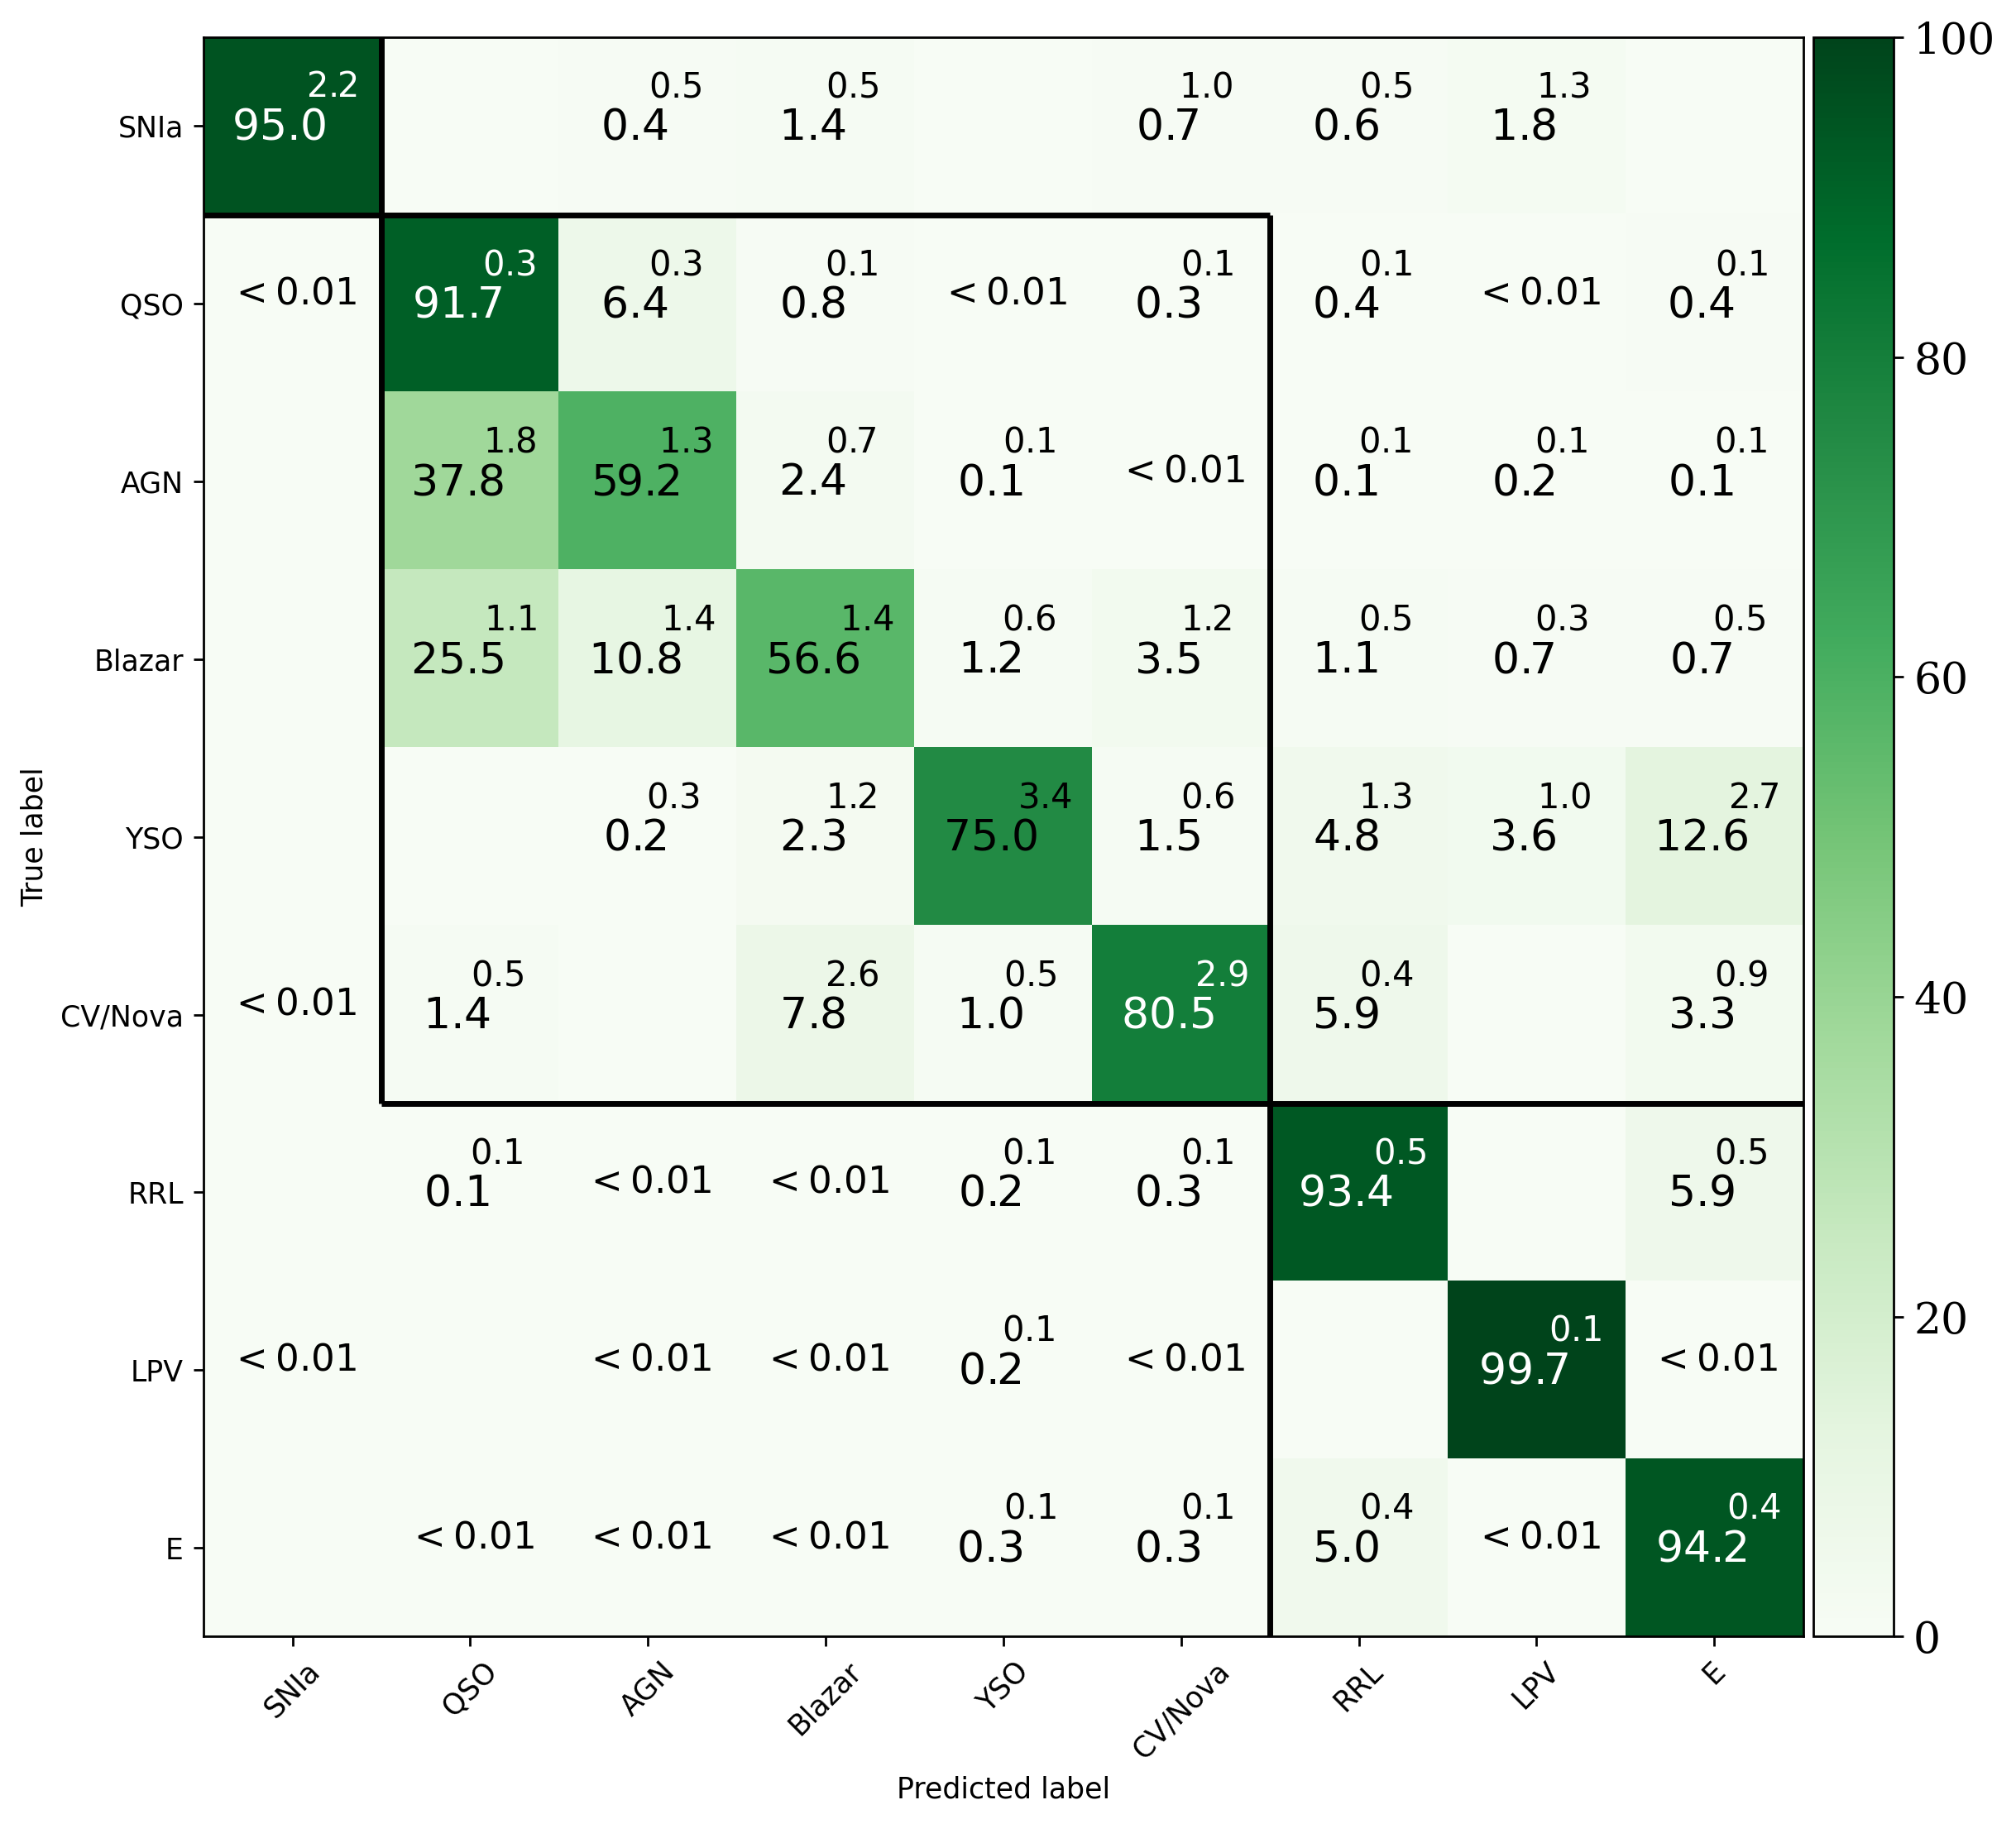

In [8]:
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='ZTF', statistic=statistic, save_path=img_path)

In [9]:
statistic = 'median'
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric=statistic, label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,1.00,0.88,0.66,0.73,0.85,0.81,0.94,0.99,0.93
recall,0.95,0.92,0.60,0.57,0.76,0.82,0.93,1.00,0.94
f1-score,0.97,0.90,0.63,0.64,0.80,0.81,0.94,1.00,0.93
support,101.00,2000.00,484.00,218.00,159.00,152.00,2000.00,1863.00,2000.00


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.000000,0.000674,0.006410,0.017222,0.008936,0.008957,0.002773,0.000800,0.000831
recall,0.019802,0.002000,0.002066,0.004587,0.015723,0.013158,0.004750,0.000537,0.002000
f1-score,0.007409,0.000605,0.004553,0.001690,0.004289,0.005943,0.001527,0.000534,0.001867
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.009901,0.004054,0.015749,0.012267,0.007620,0.010093,0.001875,0.000536,0.003771
recall,0.019802,0.002250,0.014463,0.013761,0.034591,0.032895,0.001500,0.000537,0.003000
f1-score,0.005897,0.004169,0.015130,0.005732,0.011636,0.010346,0.002027,0.000668,0.001949
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
np.round(median.loc['f1-score'].mean(),3)

0.847

<Figure size 640x480 with 0 Axes>

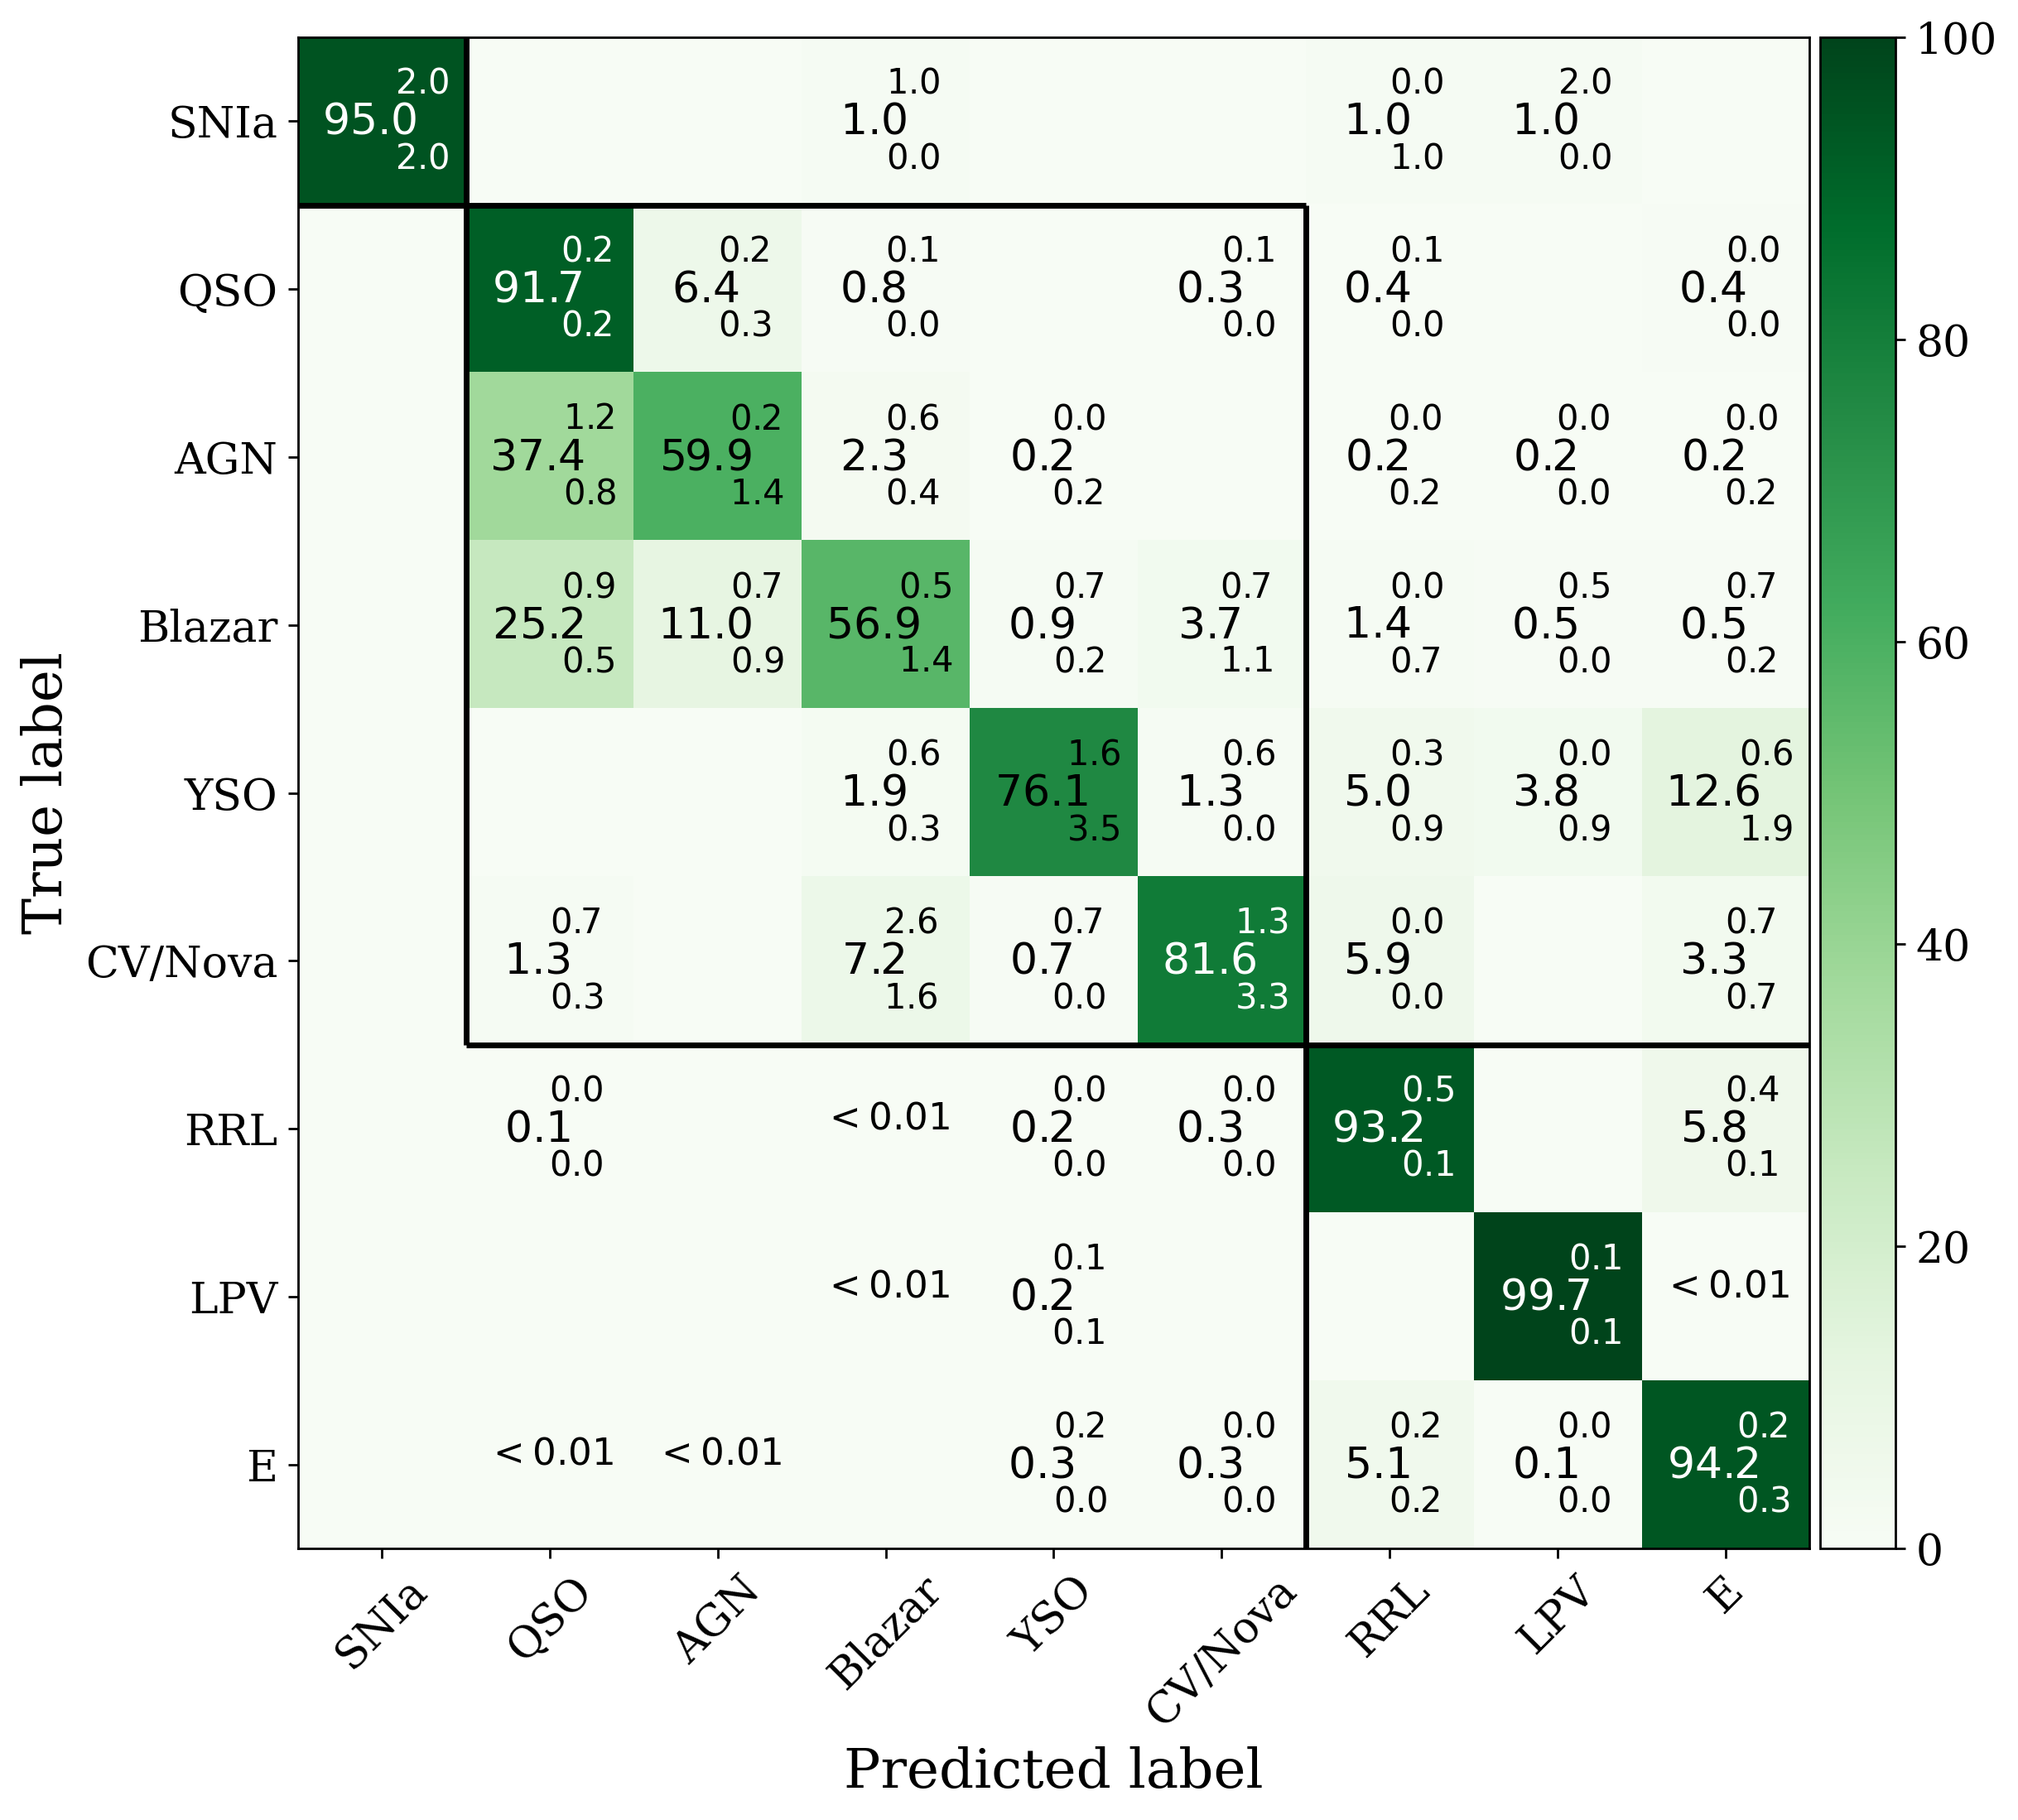

In [11]:
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='ZTF', statistic=statistic, save_path=img_path)

In [12]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),3), np.round(np.mean(accuracies),3)


(0.911, 0.912)

In [13]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.8285, 0.828)

Macro metrics

Accuracy

In [14]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.9114, 0.9123)

Macro-avg recall

In [15]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.8285, 0.828)